# Scientific Computing: Diffusion Limited Aggregation and Reaction Diffusion

## Imports

In [3]:
import numpy as np
from IPython.display import HTML

import src.solutions as solutions
import src.visualizations as visualizations

In [4]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [5]:
def visualize_object_grid(obj_grid, stage):
    """
    Visualizes a 2x2 grid of object configurations using binary occupancy maps.

    Parameters:
        obj_grids (list of list of ndarray): A list containing four object grid configurations (2D).
        sizes (list of str): A list of four labels corresponding to the object configurations.
    """
    plt.plot(figsize=(3.1, 3.8))

    # grey for spaces not occupied and black for occupied spaces
    cmap = mcolors.ListedColormap(["lightgrey", "black"])

    plt.imshow(obj_grid, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.title(f"Object Grids (stage = {stage})")
    # plt.savefig("plots/object_layout.png", dpi=300)
    plt.show()

In [9]:
def place_objects(N, size_object=1):
    """
    Randomly places square objects on an NxN grid.

    Parameters:
        N (int): Grid size (N × N).
        num_object (int): Number of objects to place.
        seed (int, optional): Random seed for reproducibility (default=31).
        size_object (int, optional): Side length of each square object (default=4).

    Returns:
        numpy.ndarray: NxN grid with placed objects, where occupied cells are marked as 1.
    """

    object_grid = np.zeros((N, N))
    x = int(N/2 - size_object/2)

    points = [
        (x + j, N -1- k) for j in range(size_object) for k in range(size_object)
    ]

    # set value of indexes that object occupies 1
    object_grid[tuple(zip(*points))] = 1

    return object_grid

In [21]:

def initialize_grid(N, object_grid):
    """
    Generates a grid with the specified dimensions and initializes the boundaries.
    Parameters:
        N (int): Grid size.
        object_grid (np.array): 2D matrix with 1s one places where the object is placed (0s everywhere else)
    """
    assert N > 1, "Grid size must be bigger than 1x1"
    assert object_grid.shape == (N, N), f"object_grid must have the same dimensions as {N, N}"

    grid = np.zeros((N, N))

    grid[object_grid==1] = 1
    return grid

def empty_object_places(grid, object_grid, nu):
    assert object_grid.shape == grid.shape, "object_grid must have the same dimensions as diffusion grid"
    
    emptied_grid = np.copy(grid)
    emptied_grid[object_grid==1] = 0 
    emptied_grid = np.power(emptied_grid, nu)
    total_sum = emptied_grid.sum()
    assert total_sum > 0, "Initialize object, The Advection Diffusion does not work on an empty grid"
    emptied_grid/=total_sum
    return emptied_grid.flatten()

def sequential_SOR(grid,tol, max_iters, omega, object_grid=None):
    """
    Solves using the Successive Over Relaxtion (SOR) iteration method.

    The update equation is:
        c_{i,j}^{k+1} = (omega/4) * (c_{i+1,j}^{k} + c_{i,j+1}^{k} + c_{i,j+1}^{k} + (1 - omega) c_{i,j}^{k})

    Parameters:
        grid (np.array): Grid (2D matrix).
        tol (float): Convergence tolerance.
        max_iters (int): Maximum number of iterations.
        omega (float): Relaxation factor.

    Returns:
        int: Number of iterations required to reach convergence.
        numpy.ndarray: Final grid after iterations.
    """
    N= len(grid)
    assert N > 1, (
        f"bord is {N}x{N}, but needs to be at least 2*2 for this diffusion implementation"
    )

    # grid initialisation
    # c = initialize_grid(N)

    iter = 0
    delta = float("inf")

    # while not converged
    while delta > tol and iter < max_iters:
        delta = 0

        
        # loop over all cells in the grid (except for y = 0, y=N)
        for i in range(N):
            for j in range(N):
                if object_grid is not None and object_grid[(i, j)]:
                    c_next = 1
                    continue
                # retrieve all necessary values (also regarding wrap-around)
                south = grid[i - 1, j] if i > 0 else grid[N-1, j]
                north = grid[i + 1, j] if i < N - 1 else grid[0, j]
                west = grid[i, j - 1] if j > 0 else grid[i, N - 1]
                east = grid[i, j + 1] if j < N - 1 else grid[i, 0]

                # SOR update equation
                c_next = (omega / 4) * (west + east + south + north) + (1 - omega) * grid[
                    i, j
                ]

                # check for convergence
                delta = max(delta, abs(c_next - grid[i, j]))
                grid[i, j] = c_next

        iter += 1

    return iter, grid

In [22]:
def plot_simulation_without_animation(grid, N):
    """
    Generates a visualization of the final state of a 2D diffusion simulation.

    Parameters:
        grids (list of numpy.ndarray): 2D concentration grids from the simulation.
        N (int): Grid size (number of spatial points in each dimension).
    """
    fig, ax = plt.subplots(figsize=(7, 7))

    c_plot = ax.pcolormesh(grid, cmap="viridis", edgecolors="k", linewidth=0.5)

    # plt.imshow(c, cmap="viridis", interpolation="nearest", origin="lower")
    plt.colorbar(c_plot, ax=ax, label="Concentration")
    ax.set_xticks(np.arange(N))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title("2D Diffusion")
    plt.show()



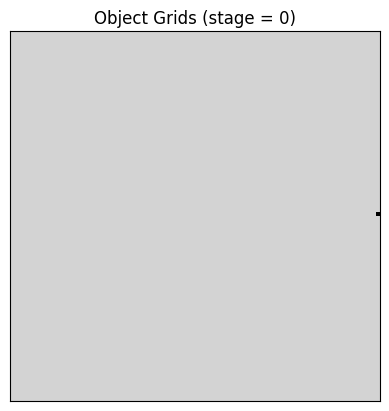

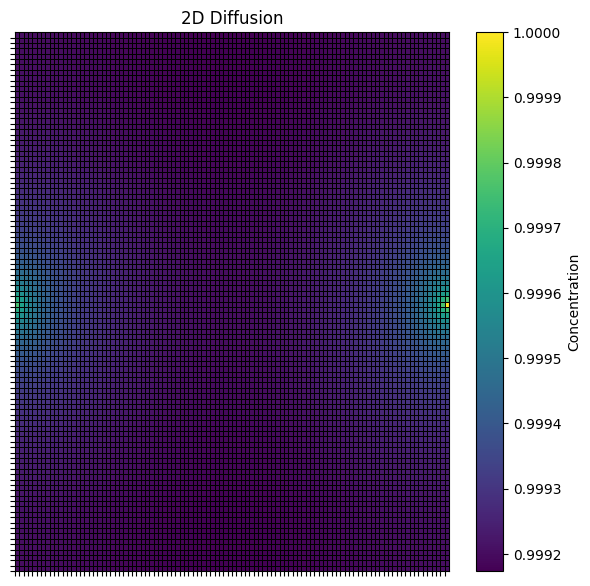

ValueError: probabilities do not sum to 1

In [ ]:
# packed parameters for easy transfer
N = 100
nu = 3
tol = 1e-6
maxiters = 10000
omega = 1.9
grid_indices = np.arange(N*N)
np.random.seed(22)


object_grid = place_objects(N)
grid =initialize_grid(N, object_grid)
visualize_object_grid(object_grid, 0)
iters, grid = sequential_SOR(grid, tol, maxiters, omega, object_grid)
plot_simulation_without_animation(grid, N)


In [ ]:
for i in range(100):
    iters, grid = sequential_SOR(grid, tol, maxiters, omega, object_grid)
    probs = empty_object_places(grid, object_grid, nu)
    selected_index = np.random.choice(grid_indices, p=probs)
    new_index = np.unravel_index(selected_index,grid.shape)
    object_grid[new_index] = 1

    if i%20 == 0:
        visualize_object_grid(object_grid, i)
